In [20]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "SF Pro Display"

In [21]:
DATA_DIR = os.path.join(os.getcwd(), "data")

TRAIN_PERIOD = pd.date_range("2011-01-05", "2015-12-31", freq="7D")
TEST_PERIOD = pd.date_range("2016-01-05", "2016-07-01", freq="7D")
BASELINE_DATE = pd.to_datetime("2002-05-21")


In [22]:
from StockHelper import Stock, StockPile, FACTORS

stocks = ["AAPL", "AXP", "AMGN", "BA", "CAT", "CVX", "CSCO", "GS"]
djia = pd.read_csv(os.path.join(DATA_DIR, "DJIA.csv"), parse_dates=["Date"])
dow30 = StockPile("DOW30", djia)
for stock in stocks:
    df_price = pd.read_csv(os.path.join(DATA_DIR, f"{stock}.csv"), parse_dates=["Date"])
    df_stats = pd.read_csv(
        os.path.join(DATA_DIR, f"{stock}_STAT.csv"), parse_dates=["Date"]
    )
    dow30.addStock(Stock(stock, df_price, df_stats))


In [23]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgbModel = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        gamma=0,
        subsample=0.2,
        colsample_bylevel=1,
        colsample_bytree=0.4,
        reg_lambda=20,
        missing=0,
    )
)


In [27]:
from StockHelper import createICDataFrame
IC_train, nextIC_train, icwithdate = createICDataFrame(dow30, TRAIN_PERIOD)


 30%|██▉       | 77/261 [00:11<00:28,  6.51it/s]/Users/thkim/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/thkim/.pyenv/versions/3.9.10/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 261/261 [00:40<00:00,  6.47it/s]


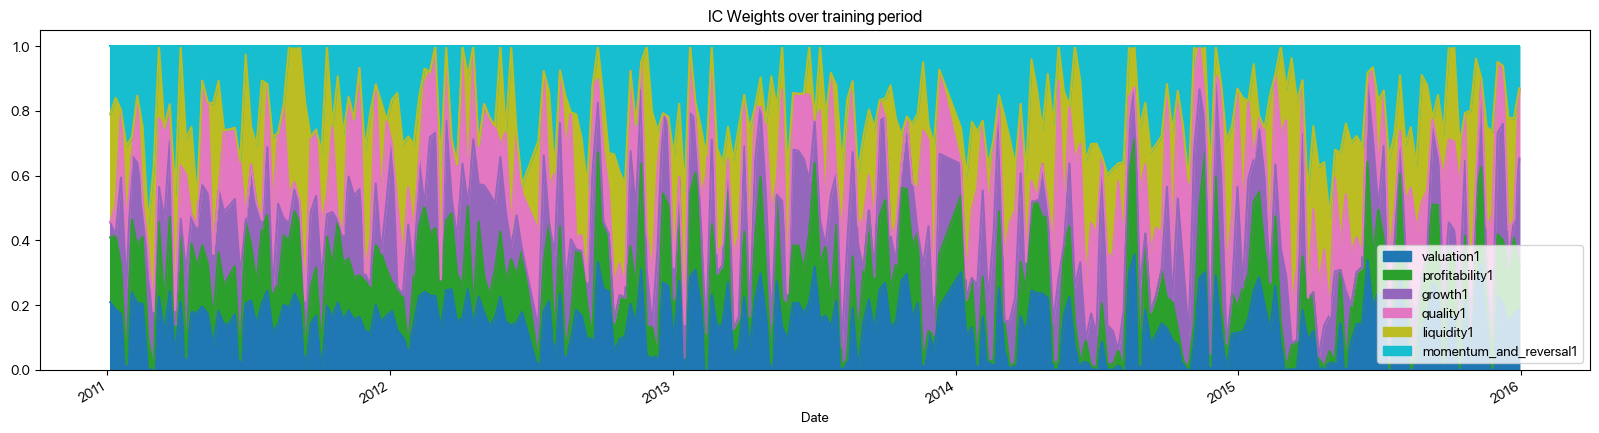

In [28]:
# IC Graph Generation
icwithdate.plot.area(
    figsize=(20, 5),
    legend=True,
    colormap="tab10",
    title="IC Weights over training period",
)
plt.savefig(dpi=300, fname="icweights.png")


In [29]:
# Model Training
print(IC_train.shape, nextIC_train.shape)
xgbModel.fit(IC_train, nextIC_train)
print(xgbModel.score(IC_train, nextIC_train))


(256, 19) (256, 6)
0.43145167526654554


In [30]:
# Model Testing
from StockHelper import createICDataFrame

IC_test, nextIC_test, _ = createICDataFrame(dow30, TEST_PERIOD)
print(IC_test.shape, nextIC_test.shape)

print(xgbModel.score(IC_test, nextIC_test))

100%|██████████| 26/26 [00:04<00:00,  6.02it/s]

(26, 19) (26, 6)
0.007692043202114622


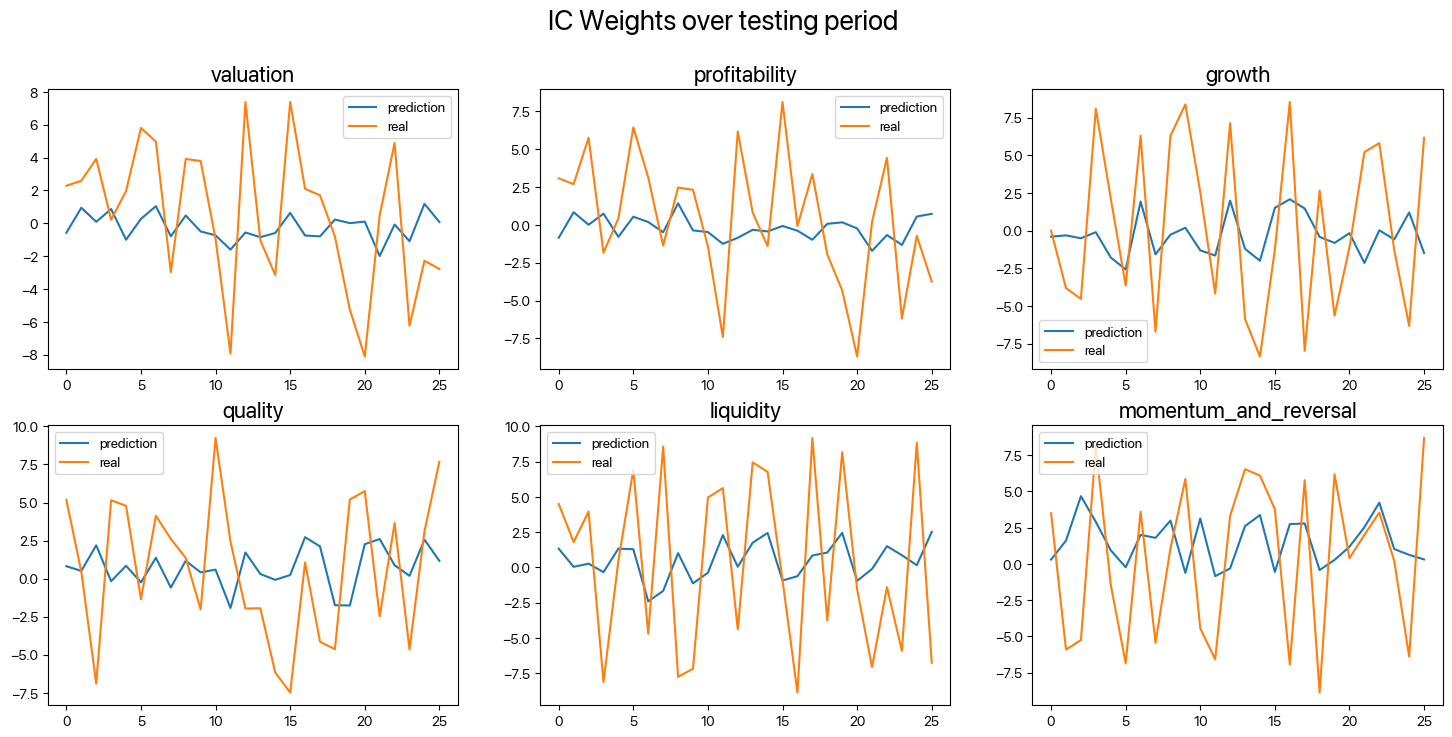

In [31]:
# Graph Plot
plt.figure(figsize=(18, 8))
plt.suptitle("IC Weights over testing period", fontsize=20)
IC_predict = pd.DataFrame(xgbModel.predict(IC_test), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict.iloc[:, i], label="prediction")
    plt.plot(nextIC_test.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")